## Download the data

In [2]:
!!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!
!curl -O https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz
!curl -O https://thor.robots.ox.ac.uk/datasets/pets/annotations.tar.gz
!
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   187  100   187    0     0   1589      0 --:--:-- --:--:-- --:--:--  1612
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   187  100   187    0     0   1425      0 --:--:-- --:--:-- --:--:--  1438
tar: Ceci ne ressemble pas à une archive de type « tar »

gzip: stdin: not in gzip format
tar: Child returned status 1
tar: Error is not recoverable: exiting now
tar: Ceci ne ressemble pas à une archive de type « tar »

gzip: stdin: not in gzip format
tar: Child returned status 1
tar: Error is not recoverable: exiting now


## Import Libraries

In [2]:
import tensorflow as tf
import keras
import pandas as pd
import os

2024-08-22 15:18:20.330475: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Prepare paths of input images and target segmentation masks

In [3]:
input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160)
num_classes = 3
batch_size = 32
num_filters_list = [32, 64, 128]

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


## What does one input image and corresponding segmentation mask look like?

2024-07-12 11:51:56.253805: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-12 11:51:56.254850: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-12 11:51:56.258037: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-12 11:51:56.265310: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-12 11:51:56.280328: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registe

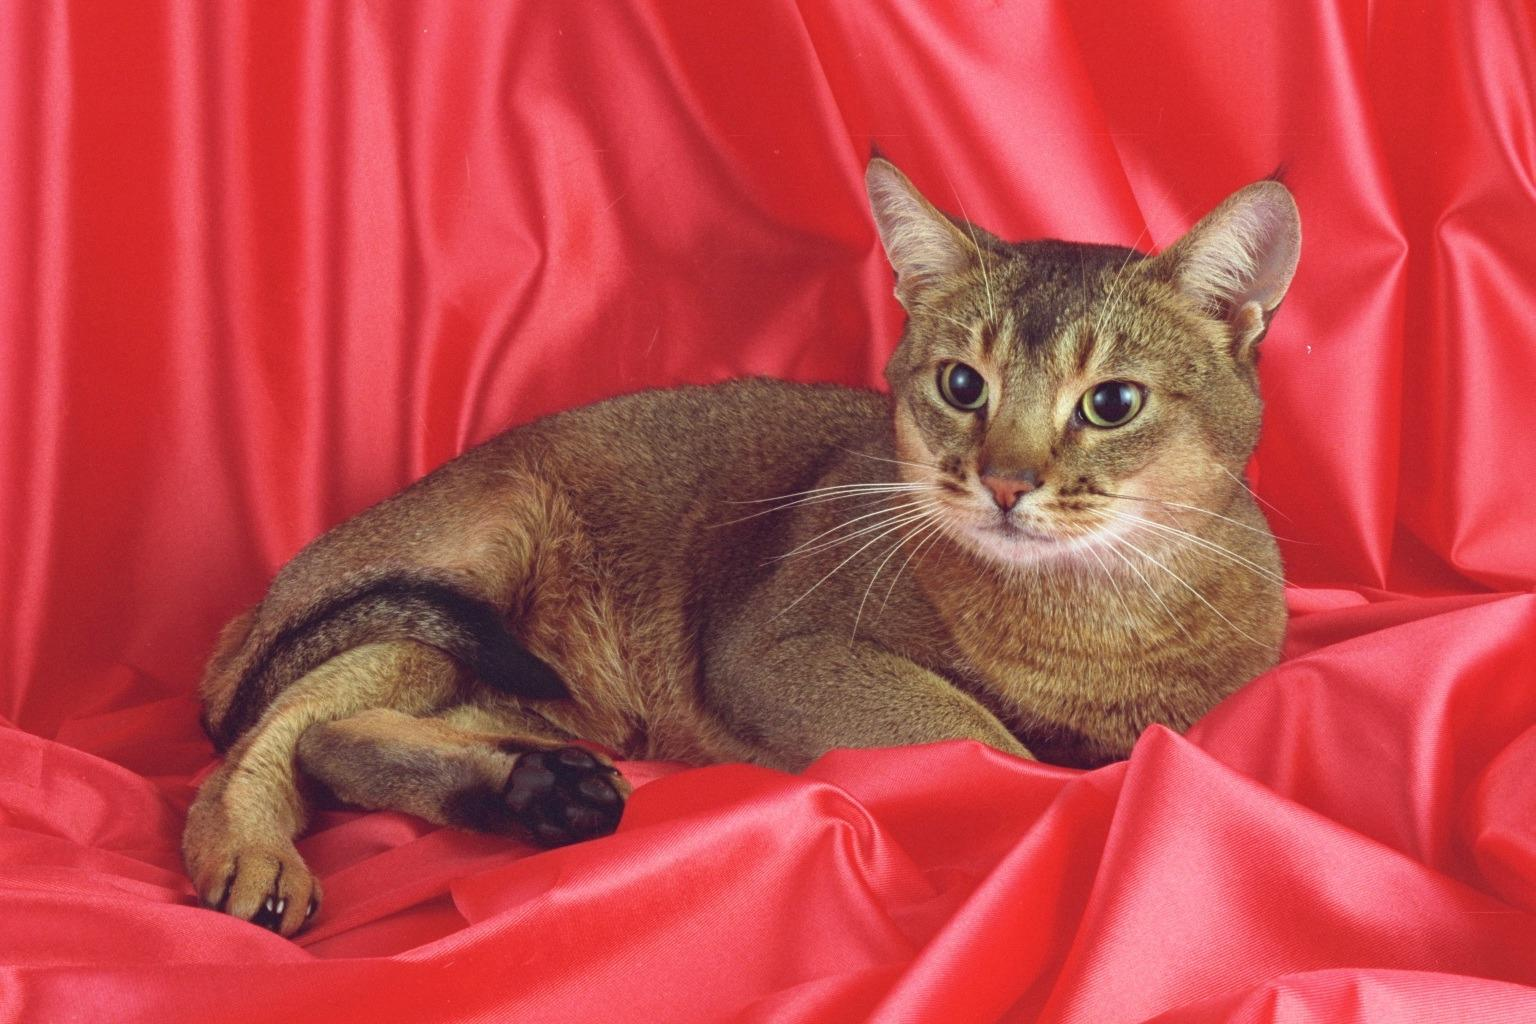

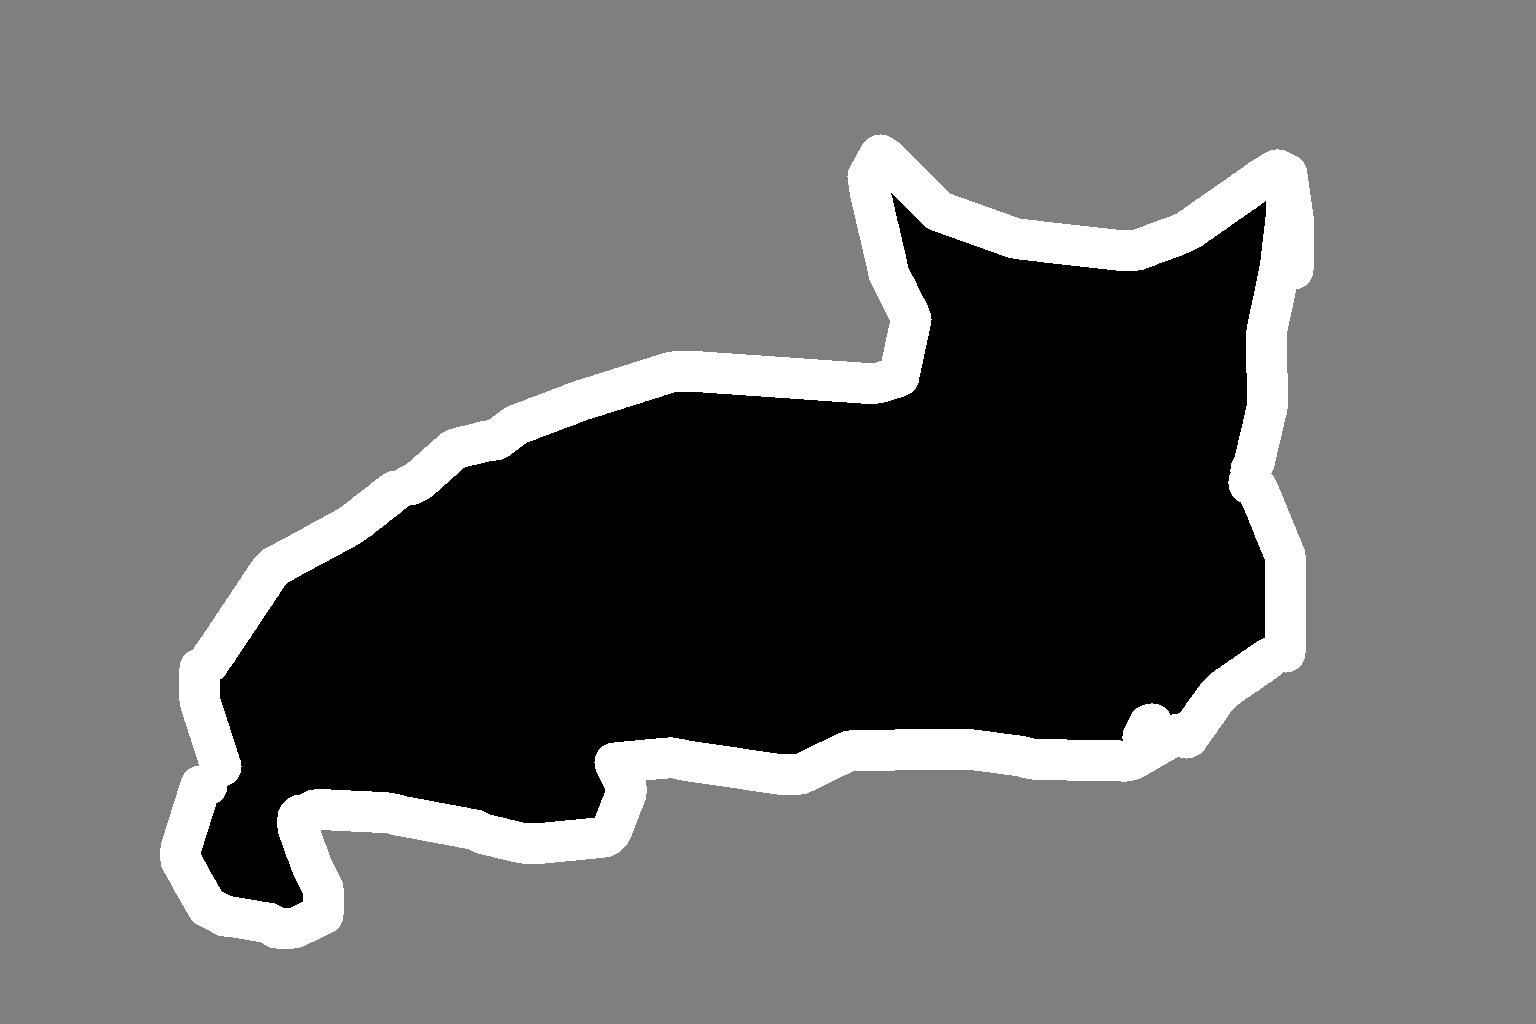

In [4]:
from IPython.display import Image, display
from keras.utils import load_img
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[8]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(load_img(target_img_paths[8]))
display(img)

## Split dataset

In [4]:
import random

random_seed = 42

random.Random(random_seed).shuffle(input_img_paths)
random.Random(random_seed).shuffle(target_img_paths)

# Split our img paths into training, validation, and test sets (80:10:10)
total_samples = len(input_img_paths)
train_end = int(0.8 * total_samples)
val_end = int(0.9 * total_samples)

train_input_img_paths = input_img_paths[:train_end]
train_target_img_paths = target_img_paths[:train_end]
val_input_img_paths = input_img_paths[train_end:val_end]
val_target_img_paths = target_img_paths[train_end:val_end]
test_input_img_paths = input_img_paths[val_end:]
test_target_img_paths = target_img_paths[val_end:]

print("Train dataset: ", len(train_input_img_paths))
print("Validation dataset:", len(val_input_img_paths))
print("Test dataset:", len(test_input_img_paths))
for input_path, target_path in zip(train_input_img_paths[:10], train_target_img_paths[:10]):
    print(input_path, "|", target_path)


Train dataset:  5912
Validation dataset: 739
Test dataset: 739
images/samoyed_64.jpg | annotations/trimaps/samoyed_64.png
images/yorkshire_terrier_21.jpg | annotations/trimaps/yorkshire_terrier_21.png
images/shiba_inu_143.jpg | annotations/trimaps/shiba_inu_143.png
images/pomeranian_86.jpg | annotations/trimaps/pomeranian_86.png
images/boxer_85.jpg | annotations/trimaps/boxer_85.png
images/Birman_17.jpg | annotations/trimaps/Birman_17.png
images/beagle_64.jpg | annotations/trimaps/beagle_64.png
images/german_shorthaired_182.jpg | annotations/trimaps/german_shorthaired_182.png
images/staffordshire_bull_terrier_194.jpg | annotations/trimaps/staffordshire_bull_terrier_194.png
images/Egyptian_Mau_218.jpg | annotations/trimaps/Egyptian_Mau_218.png


## Save and Load data paths

In [8]:
import pickle

# Function to save paths to a file
def save_paths_file(paths, file_name):
    """Save the list of paths to a file."""
    with open(f"./paths/{file_name}.pkl", "wb") as file:
        pickle.dump(paths, file)
    
# Save test_input_img_paths to a file
save_paths_file(train_input_img_paths, "train_input_img_paths")
save_paths_file(train_target_img_paths, "train_target_img_paths")
save_paths_file(val_input_img_paths, "val_input_img_paths")
save_paths_file(val_target_img_paths, "val_target_img_paths")
save_paths_file(test_input_img_paths, "test_input_img_paths")
save_paths_file(test_target_img_paths, "test_target_img_paths")

print("Data paths saved")

Data paths saved


In [7]:
# Load the list from the file using pickle
def load_paths_file(file_name):
    with open(f"./paths/{file_name}.pkl", "rb") as file:
        paths = pickle.load(file)
    return paths

train_input_img_paths = load_paths_file("train_input_img_paths")
train_target_img_paths = load_paths_file("train_target_img_paths")
val_input_img_paths = load_paths_file("val_input_img_paths")
val_target_img_paths = load_paths_file("val_target_img_paths")
test_input_img_paths = load_paths_file("test_input_img_paths")
test_target_img_paths = load_paths_file("test_target_img_paths")

print("Data paths loaded")

Data paths loaded


## Prepare dataset to load & vectorize batches of data

In [6]:
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io

def get_dataset(
    batch_size,
    img_size,
    input_img_paths,
    target_img_paths,
    max_dataset_len=None,
):
    """Returns a TF Dataset."""

    def load_img_masks(input_img_path, target_img_path):
        input_img = tf_io.read_file(input_img_path)
        input_img = tf_io.decode_png(input_img, channels=3)
        input_img = tf_image.resize(input_img, img_size)
        input_img = tf_image.convert_image_dtype(input_img, "float32")

        target_img = tf_io.read_file(target_img_path)
        target_img = tf_io.decode_png(target_img, channels=1)
        target_img = tf_image.resize(target_img, img_size, method="nearest")
        target_img = tf_image.convert_image_dtype(target_img, "uint8")

        # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
        target_img -= 1
        return input_img, target_img

    # For faster debugging, limit the size of data
    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
        target_img_paths = target_img_paths[:max_dataset_len]
    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)


In [7]:
train_dataset = get_dataset(
    batch_size,
    img_size,
    train_input_img_paths,
    train_target_img_paths,
)
valid_dataset = get_dataset(
    batch_size, 
    img_size, 
    val_input_img_paths, 
    val_target_img_paths
)
test_dataset = get_dataset(
    batch_size, 
    img_size, 
    test_input_img_paths, 
    test_target_img_paths
)

2024-07-12 11:51:57.704762: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Save and Load dataset

In [8]:
train_dataset_path = 'saved_data/train_dataset'
valid_dataset_path = 'saved_data/valid_dataset'
test_dataset_path = 'saved_data/test_dataset'

# Save datasets
tf.data.Dataset.save(train_dataset, train_dataset_path)
tf.data.Dataset.save(valid_dataset, valid_dataset_path)
tf.data.Dataset.save(test_dataset, test_dataset_path)

print("Datasets saved.")

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Datasets saved.


In [9]:
train_dataset_path = 'saved_data/train_dataset'
valid_dataset_path = 'saved_data/valid_dataset'
test_dataset_path = 'saved_data/test_dataset'

# Load datasets
train_dataset = tf.data.Dataset.load(train_dataset_path)
valid_dataset = tf.data.Dataset.load(valid_dataset_path)
test_dataset = tf.data.Dataset.load(test_dataset_path)

print("Datasets loaded.")

Datasets loaded.


## Prepare U-Net Xception-style model

In [11]:

from keras import layers

def get_model(img_size, num_classes, num_filters, normalization=True):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(num_filters, 3, strides=2, padding="same")(inputs)
    if normalization:
        x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [num_filters*(2**i) for i in range(1,4)]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        if normalization:
            x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        if normalization:
            x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [num_filters*(2**i) for i in range(3,-1,-1)]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        if normalization:
            x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        if normalization:
            x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

## Train the model

In [ ]:
import time
import psutil

# Directory to save models
saved_model_dir = "./saved_models"
os.makedirs(saved_model_dir, exist_ok=True)

epochs_list = [50,100]
histories = []
metrics_df = pd.DataFrame(columns=['num_filters', 'normalization', 'epochs', 'total_time', 'memory_usage'])

# Train the model, doing validation at the end of each epoch.
callbacks = [
    keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True)
]

for num_filters in num_filters_list:
    for normalization in [True, False]:
        for epochs in epochs_list:
            model = get_model(img_size, num_classes, num_filters, normalization)
            model.compile(optimizer=keras.optimizers.Adam(1e-4), loss="sparse_categorical_crossentropy")

            start_time = time.time()
            memory_usage = []
            
            # Train model
            history = model.fit(
                train_dataset,
                epochs=epochs,
                validation_data=valid_dataset,
                callbacks=callbacks,
                verbose=2,
            )
                       
            # Get current memory usage
            memory_info = psutil.virtual_memory()
            memory_usage.append(memory_info.used / (1024 ** 3))  # Convert to GB
            total_time = time.time() - start_time
            
            # Save history
            histories.append({
                'num_filters': num_filters,
                'normalization': normalization,
                'epochs': epochs,
                'history': history.history
            })

            # Save model
            norm_status = "with_batch_norm" if normalization else "without_batch_norm"
            model_name = f"model_epochs_{epochs}_filters_{num_filters}_{norm_status}"
            save_path = os.path.join(saved_model_dir, model_name)
            tf.saved_model.save(model, save_path)
            print(f"Model saved to: {save_path}")

            # Save metrics
            new_metrics = pd.DataFrame({
                'num_filters': [num_filters],
                'normalization': [normalization],
                'epochs': [epochs],
                'total_time': [total_time],
                'memory_usage': [memory_usage]
            })

            metrics_df = pd.concat([metrics_df, new_metrics], ignore_index=True)



Epoch 1/50


2024-07-12 11:52:06.819000: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


185/185 - 52s - 283ms/step - loss: 0.8738 - val_loss: 2.9438
Epoch 2/50
185/185 - 46s - 249ms/step - loss: 0.6309 - val_loss: 3.5717
Epoch 3/50
185/185 - 46s - 250ms/step - loss: 0.5721 - val_loss: 1.3996
Epoch 4/50
185/185 - 46s - 251ms/step - loss: 0.5310 - val_loss: 0.5501
Epoch 5/50
185/185 - 46s - 251ms/step - loss: 0.4985 - val_loss: 0.5227
Epoch 6/50
185/185 - 46s - 251ms/step - loss: 0.4712 - val_loss: 0.5107
Epoch 7/50
185/185 - 46s - 251ms/step - loss: 0.4469 - val_loss: 0.5005
Epoch 8/50
185/185 - 46s - 251ms/step - loss: 0.4237 - val_loss: 0.4891
Epoch 9/50
185/185 - 46s - 250ms/step - loss: 0.4000 - val_loss: 0.4897
Epoch 10/50
185/185 - 46s - 249ms/step - loss: 0.3755 - val_loss: 0.4982
Epoch 11/50
185/185 - 46s - 249ms/step - loss: 0.3512 - val_loss: 0.5121
Epoch 12/50
185/185 - 46s - 249ms/step - loss: 0.3271 - val_loss: 0.5516
Epoch 13/50
185/185 - 46s - 249ms/step - loss: 0.3076 - val_loss: 0.5822
Epoch 14/50
185/185 - 46s - 249ms/step - loss: 0.3084 - val_loss: 0.618

INFO:tensorflow:Assets written to: ./saved_models/model_epochs_50_filters_32_with_batch_norm/assets


Model saved to: ./saved_models/model_epochs_50_filters_32_with_batch_norm
Epoch 1/100


/tmp/ipykernel_3658999/1740538479.py:70: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, new_metrics], ignore_index=True)


185/185 - 53s - 286ms/step - loss: 0.9958 - val_loss: 4.6945
Epoch 2/100
185/185 - 46s - 249ms/step - loss: 0.6727 - val_loss: 5.4867
Epoch 3/100
185/185 - 46s - 249ms/step - loss: 0.6075 - val_loss: 2.0137
Epoch 4/100
185/185 - 46s - 249ms/step - loss: 0.5661 - val_loss: 0.5933
Epoch 5/100
185/185 - 46s - 249ms/step - loss: 0.5320 - val_loss: 0.5882
Epoch 6/100
185/185 - 46s - 249ms/step - loss: 0.5035 - val_loss: 0.5450
Epoch 7/100
185/185 - 46s - 249ms/step - loss: 0.4786 - val_loss: 0.5177
Epoch 8/100
185/185 - 46s - 250ms/step - loss: 0.4556 - val_loss: 0.5139
Epoch 9/100
185/185 - 46s - 249ms/step - loss: 0.4333 - val_loss: 0.5103
Epoch 10/100
185/185 - 46s - 249ms/step - loss: 0.4111 - val_loss: 0.5073
Epoch 11/100
185/185 - 46s - 248ms/step - loss: 0.3884 - val_loss: 0.5113
Epoch 12/100
185/185 - 46s - 249ms/step - loss: 0.3651 - val_loss: 0.5207
Epoch 13/100
185/185 - 46s - 249ms/step - loss: 0.3429 - val_loss: 0.5382
Epoch 14/100
185/185 - 46s - 248ms/step - loss: 0.3230 - va

INFO:tensorflow:Assets written to: ./saved_models/model_epochs_100_filters_32_with_batch_norm/assets


Model saved to: ./saved_models/model_epochs_100_filters_32_with_batch_norm
Epoch 1/50
185/185 - 30s - 162ms/step - loss: 5.7217 - val_loss: 1.7779
Epoch 2/50
185/185 - 26s - 141ms/step - loss: 1.5909 - val_loss: 1.1953
Epoch 3/50
185/185 - 26s - 141ms/step - loss: 1.1760 - val_loss: 0.9807
Epoch 4/50
185/185 - 26s - 142ms/step - loss: 0.9933 - val_loss: 0.8789
Epoch 5/50
185/185 - 26s - 141ms/step - loss: 0.8924 - val_loss: 0.8259
Epoch 6/50
185/185 - 26s - 141ms/step - loss: 0.8288 - val_loss: 0.8185
Epoch 7/50
185/185 - 26s - 141ms/step - loss: 0.7847 - val_loss: 0.8212
Epoch 8/50
185/185 - 26s - 141ms/step - loss: 0.7553 - val_loss: 0.7819
Epoch 9/50
185/185 - 26s - 141ms/step - loss: 0.7282 - val_loss: 0.7373
Epoch 10/50
185/185 - 26s - 141ms/step - loss: 0.7041 - val_loss: 0.7099
Epoch 11/50
185/185 - 26s - 141ms/step - loss: 0.6852 - val_loss: 0.6914
Epoch 12/50
185/185 - 26s - 142ms/step - loss: 0.6694 - val_loss: 0.6728
Epoch 13/50
185/185 - 26s - 141ms/step - loss: 0.6558 - va

INFO:tensorflow:Assets written to: ./saved_models/model_epochs_50_filters_32_without_batch_norm/assets


Model saved to: ./saved_models/model_epochs_50_filters_32_without_batch_norm
Epoch 1/100
185/185 - 30s - 162ms/step - loss: 4.7328 - val_loss: 1.4228
Epoch 2/100
185/185 - 26s - 141ms/step - loss: 1.2938 - val_loss: 1.0902
Epoch 3/100
185/185 - 26s - 142ms/step - loss: 1.0159 - val_loss: 0.9795
Epoch 4/100
185/185 - 26s - 142ms/step - loss: 0.8872 - val_loss: 0.8901
Epoch 5/100
185/185 - 26s - 142ms/step - loss: 0.8156 - val_loss: 0.8176
Epoch 6/100
185/185 - 26s - 142ms/step - loss: 0.7664 - val_loss: 0.7681
Epoch 7/100
185/185 - 26s - 142ms/step - loss: 0.7318 - val_loss: 0.7333
Epoch 8/100
185/185 - 26s - 142ms/step - loss: 0.7057 - val_loss: 0.7065
Epoch 9/100
185/185 - 26s - 142ms/step - loss: 0.6847 - val_loss: 0.6837
Epoch 10/100
185/185 - 26s - 142ms/step - loss: 0.6668 - val_loss: 0.6646
Epoch 11/100
185/185 - 26s - 142ms/step - loss: 0.6520 - val_loss: 0.6485
Epoch 12/100
185/185 - 26s - 142ms/step - loss: 0.6385 - val_loss: 0.6341
Epoch 13/100
185/185 - 26s - 142ms/step - lo

INFO:tensorflow:Assets written to: ./saved_models/model_epochs_100_filters_32_without_batch_norm/assets


Model saved to: ./saved_models/model_epochs_100_filters_32_without_batch_norm
Epoch 1/50
185/185 - 110s - 597ms/step - loss: 0.8824 - val_loss: 2.5886
Epoch 2/50
185/185 - 104s - 562ms/step - loss: 0.5971 - val_loss: 3.6718
Epoch 3/50
185/185 - 104s - 563ms/step - loss: 0.5283 - val_loss: 2.6532
Epoch 4/50
185/185 - 104s - 563ms/step - loss: 0.4771 - val_loss: 0.5383
Epoch 5/50
185/185 - 105s - 566ms/step - loss: 0.4346 - val_loss: 0.4846
Epoch 6/50
185/185 - 104s - 563ms/step - loss: 0.3939 - val_loss: 0.4861
Epoch 7/50
185/185 - 104s - 562ms/step - loss: 0.3507 - val_loss: 0.4947
Epoch 8/50
185/185 - 104s - 563ms/step - loss: 0.3075 - val_loss: 0.5492
Epoch 9/50
185/185 - 104s - 563ms/step - loss: 0.2874 - val_loss: 0.5774
Epoch 10/50
185/185 - 104s - 563ms/step - loss: 0.2977 - val_loss: 0.5920
Epoch 11/50
185/185 - 104s - 563ms/step - loss: 0.2883 - val_loss: 0.7025
Epoch 12/50
185/185 - 104s - 563ms/step - loss: 0.2742 - val_loss: 0.5249
Epoch 13/50
185/185 - 104s - 563ms/step - l

INFO:tensorflow:Assets written to: ./saved_models/model_epochs_50_filters_64_with_batch_norm/assets


Model saved to: ./saved_models/model_epochs_50_filters_64_with_batch_norm
Epoch 1/100
185/185 - 111s - 598ms/step - loss: 0.8977 - val_loss: 4.0025
Epoch 2/100
185/185 - 104s - 563ms/step - loss: 0.5966 - val_loss: 4.6143
Epoch 3/100
185/185 - 105s - 568ms/step - loss: 0.5270 - val_loss: 2.7231
Epoch 4/100
185/185 - 104s - 563ms/step - loss: 0.4787 - val_loss: 0.5557
Epoch 5/100
185/185 - 104s - 563ms/step - loss: 0.4372 - val_loss: 0.4861
Epoch 6/100
185/185 - 104s - 563ms/step - loss: 0.3979 - val_loss: 0.4935
Epoch 7/100
185/185 - 104s - 562ms/step - loss: 0.3570 - val_loss: 0.5131
Epoch 8/100
185/185 - 104s - 563ms/step - loss: 0.3188 - val_loss: 0.5622
Epoch 9/100
185/185 - 104s - 564ms/step - loss: 0.3082 - val_loss: 0.7753
Epoch 10/100
185/185 - 104s - 563ms/step - loss: 0.3161 - val_loss: 0.6793
Epoch 11/100
185/185 - 104s - 564ms/step - loss: 0.2897 - val_loss: 0.5378
Epoch 12/100
185/185 - 104s - 563ms/step - loss: 0.2561 - val_loss: 0.5991
Epoch 13/100
185/185 - 104s - 563ms

INFO:tensorflow:Assets written to: ./saved_models/model_epochs_100_filters_64_with_batch_norm/assets


Model saved to: ./saved_models/model_epochs_100_filters_64_with_batch_norm
Epoch 1/50
185/185 - 76s - 413ms/step - loss: 6.0775 - val_loss: 1.0797
Epoch 2/50
185/185 - 72s - 391ms/step - loss: 1.0907 - val_loss: 1.0172
Epoch 3/50
185/185 - 72s - 391ms/step - loss: 0.8808 - val_loss: 0.7770
Epoch 4/50
185/185 - 72s - 391ms/step - loss: 0.8163 - val_loss: 0.7586
Epoch 5/50
185/185 - 72s - 391ms/step - loss: 0.7574 - val_loss: 0.7154
Epoch 6/50
185/185 - 72s - 391ms/step - loss: 0.7263 - val_loss: 0.7199
Epoch 7/50
185/185 - 72s - 391ms/step - loss: 0.6926 - val_loss: 0.7174
Epoch 8/50
185/185 - 72s - 391ms/step - loss: 0.6695 - val_loss: 0.6831
Epoch 9/50
185/185 - 72s - 391ms/step - loss: 0.6483 - val_loss: 0.6646
Epoch 10/50
185/185 - 72s - 391ms/step - loss: 0.6303 - val_loss: 0.6657
Epoch 11/50
185/185 - 72s - 390ms/step - loss: 0.6153 - val_loss: 0.6656
Epoch 12/50
185/185 - 72s - 391ms/step - loss: 0.5988 - val_loss: 0.6031
Epoch 13/50
185/185 - 72s - 391ms/step - loss: 0.5800 - va

INFO:tensorflow:Assets written to: ./saved_models/model_epochs_50_filters_64_without_batch_norm/assets


Model saved to: ./saved_models/model_epochs_50_filters_64_without_batch_norm
Epoch 1/100
185/185 - 76s - 409ms/step - loss: 3.7765 - val_loss: 0.8970
Epoch 2/100
185/185 - 72s - 391ms/step - loss: 0.8946 - val_loss: 0.7752
Epoch 3/100
185/185 - 72s - 391ms/step - loss: 0.7906 - val_loss: 0.7669
Epoch 4/100
185/185 - 72s - 391ms/step - loss: 0.7389 - val_loss: 0.7488
Epoch 5/100
185/185 - 72s - 391ms/step - loss: 0.7015 - val_loss: 0.6958
Epoch 6/100
185/185 - 72s - 391ms/step - loss: 0.6729 - val_loss: 0.6544
Epoch 7/100
185/185 - 72s - 391ms/step - loss: 0.6509 - val_loss: 0.6337
Epoch 8/100
185/185 - 72s - 392ms/step - loss: 0.6329 - val_loss: 0.6382
Epoch 9/100
185/185 - 72s - 391ms/step - loss: 0.6108 - val_loss: 0.6111
Epoch 10/100
185/185 - 72s - 391ms/step - loss: 0.5936 - val_loss: 0.5970
Epoch 11/100
185/185 - 72s - 391ms/step - loss: 0.5757 - val_loss: 0.5918
Epoch 12/100
185/185 - 72s - 391ms/step - loss: 0.5594 - val_loss: 0.5897
Epoch 13/100
185/185 - 72s - 391ms/step - lo

INFO:tensorflow:Assets written to: ./saved_models/model_epochs_100_filters_64_without_batch_norm/assets


Model saved to: ./saved_models/model_epochs_100_filters_64_without_batch_norm
Epoch 1/50
185/185 - 307s - 2s/step - loss: 0.9402 - val_loss: 3.2759
Epoch 2/50
185/185 - 301s - 2s/step - loss: 0.5531 - val_loss: 4.3805
Epoch 3/50


In [18]:
print(metrics_df)

   num_filters normalization epochs    total_time          memory_usage
0           32          True     50   2310.674366  [10.486068725585938]
1           32          True    100   4603.210808  [11.231391906738281]
2           32         False     50   1310.988504  [11.455856323242188]
3           32         False    100   2627.638040  [11.728103637695312]
4           64          True     50   5217.027660  [17.307300567626953]
5           64          True    100  10421.579197  [18.414154052734375]
6           64         False     50   3620.702859  [18.567462921142578]
7           64         False    100   7238.686363  [18.674671173095703]
8          128          True     50  15067.159749   [23.45050811767578]
9          128          True    100  30119.486756  [24.143447875976562]
10         128         False     50  12101.984716  [24.248722076416016]
11         128         False    100  24169.840243  [24.211227416992188]


In [ ]:
# Save metrics to CSV
metrics_df.to_csv('trained_models_info.csv', index=False)

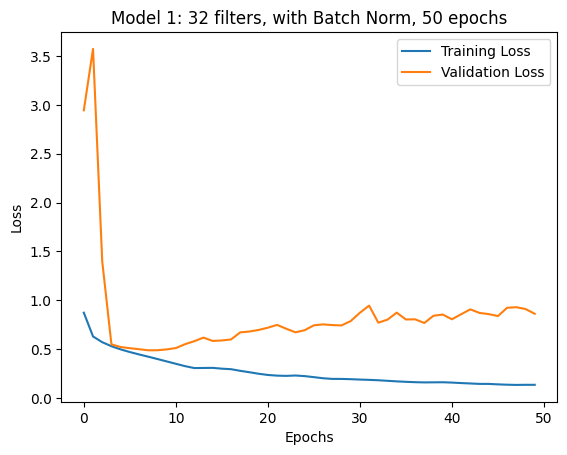

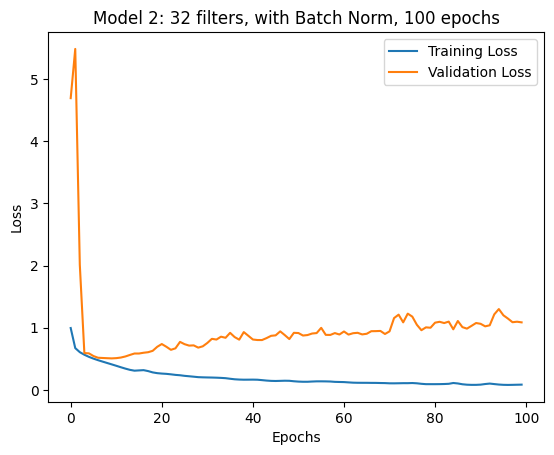

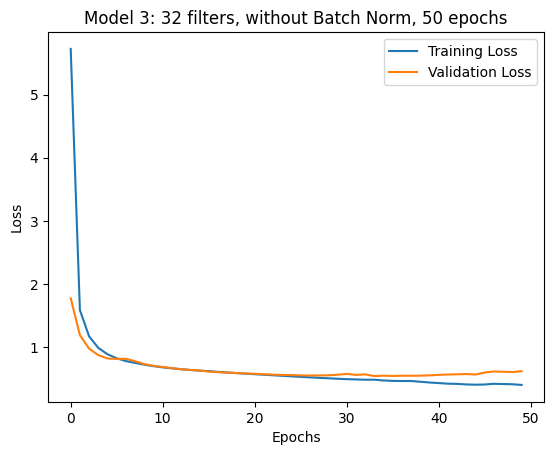

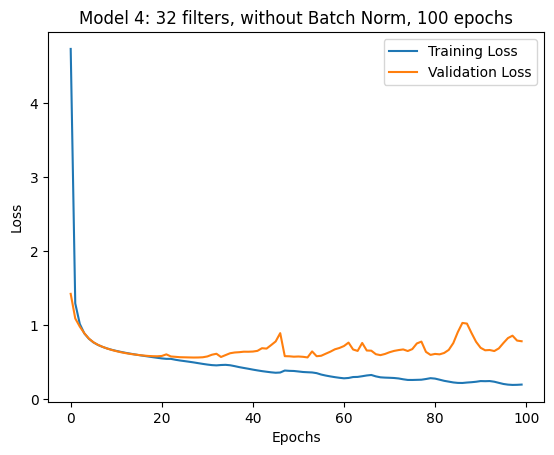

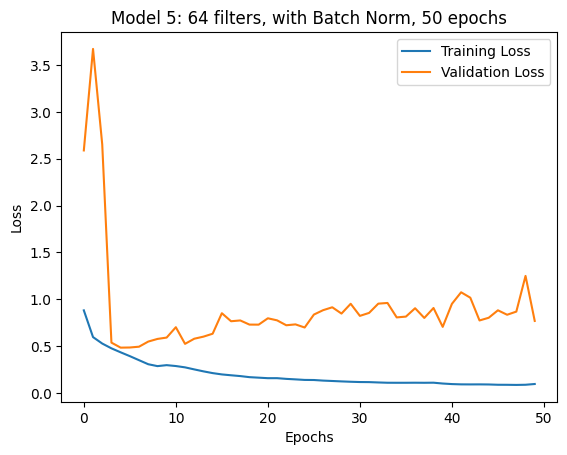

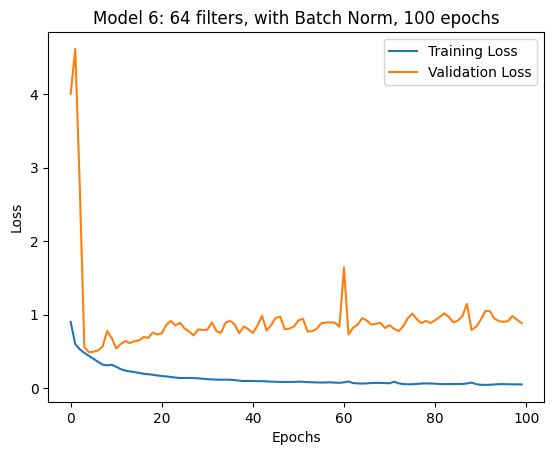

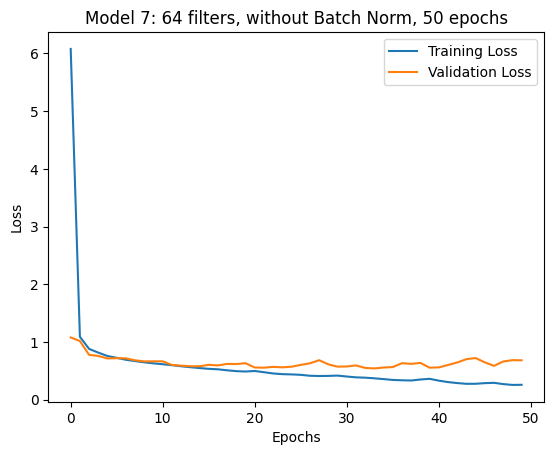

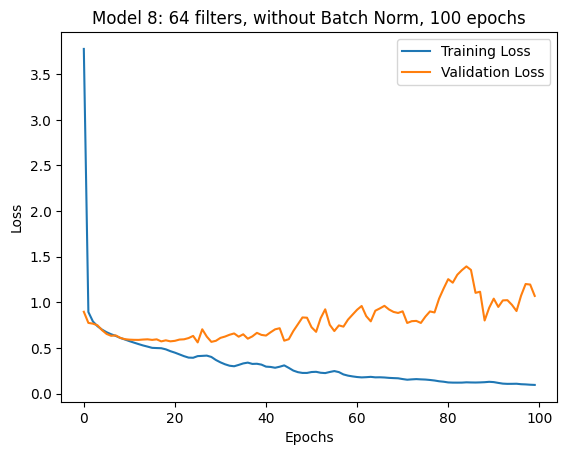

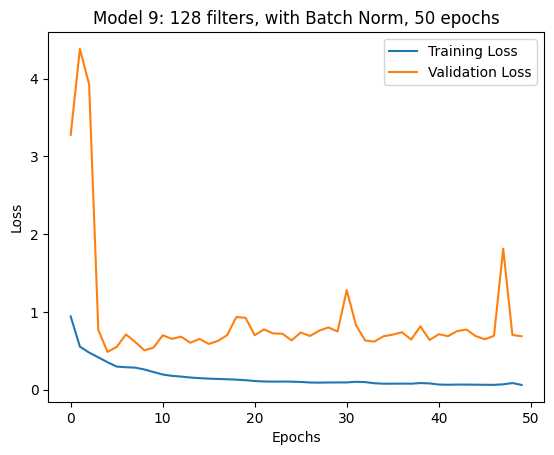

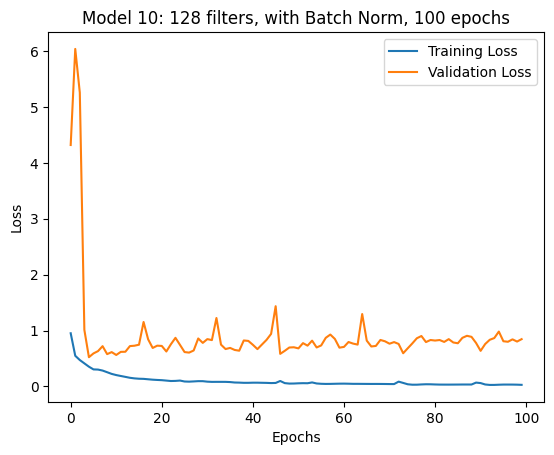

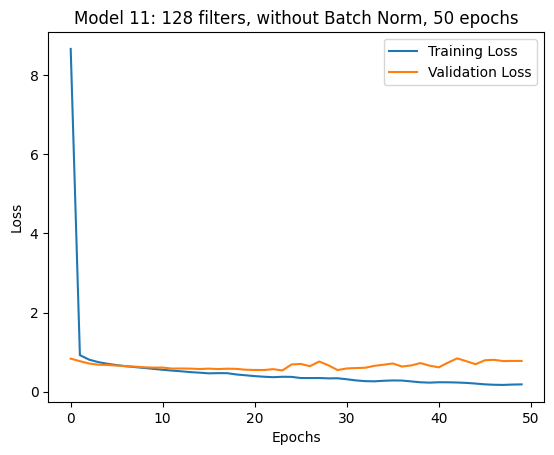

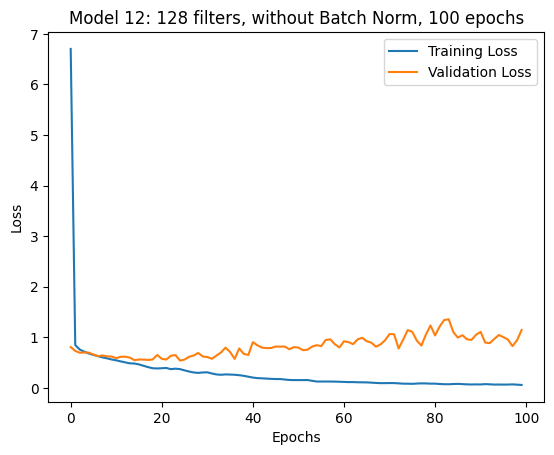

In [17]:
import matplotlib.pyplot as plt

# Plot the training and validation loss for each model
for i, history_dict in enumerate(histories):
    plt.figure()
    plt.plot(history_dict['history']['loss'], label='Training Loss')
    plt.plot(history_dict['history']['val_loss'], label='Validation Loss')
    plt.title(f"Model {i+1}: {history_dict['num_filters']} filters, " +
              f"{'with' if history_dict['normalization'] else 'without'} Batch Norm, " +
              f"{history_dict['epochs']} epochs")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## Convert our model using Tensorflow Lite

In [21]:
# Load existing CSV into a DataFrame
metrics_df = pd.read_csv('trained_models_info.csv')

quantization_types = ['default','float16', 'int8']

for base_model_info in metrics_df.itertuples():
    model_path = os.path.join(
        saved_model_dir,
        f"model_epochs_{base_model_info.epochs}_filters_{base_model_info.num_filters}_{'with_batch_norm' if base_model_info.normalization else 'without_batch_norm'}"
    )
    # Load the model using the SavedModel format
    model = tf.saved_model.load(model_path)
    
    for quantization in quantization_types:
        converter = tf.lite.TFLiteConverter.from_keras_model(model)  
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
        # if quantization != 'default':
            
        if quantization == 'float16':            
            converter.target_spec.supported_types = [tf.float16]            
        elif quantization == 'int8':
            def representative_data_gen():
                for input_value, _ in train_dataset.take(100):
                    yield [input_value]
            converter.representative_dataset = representative_data_gen
        tflite_model = converter.convert()
        
        model_name = f"model_epochs_{base_model_info.epochs}_filters_{base_model_info.num_filters}_{'with_batch_norm' if base_model_info.normalization else 'without_batch_norm'}_{quantization}.tflite"
        save_path = os.path.join(saved_model_dir, model_name)
        with open(save_path, 'wb') as f:
            f.write(tflite_model)
        model_size = os.path.getsize(save_path)

        print(f"Quantized model saved to: {save_path} with size {model_size} bytes")
   
        # Save metrics
        new_metrics = pd.DataFrame({
            'num_filters': [base_model_info.num_filters],
            'normalization': [base_model_info.normalization],
            'epochs': [base_model_info.epochs],
            'quantization': [quantization],
            'model_size': [model_size],
            'total_time': [base_model_info.total_time],
            'memory_usage': [base_model_info.memory_usage]
        })

        metrics_df = pd.concat([metrics_df, new_metrics], ignore_index=True)

# Save the extended metrics to CSV
metrics_df.to_csv('compressed_models_info.csv', index=False)


INFO:tensorflow:Assets written to: /tmp/tmpq1bn8s_s/assets


INFO:tensorflow:Assets written to: /tmp/tmpq1bn8s_s/assets
W0000 00:00:1721121282.465042 3658999 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1721121282.465074 3658999 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-07-16 11:14:42.465266: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpq1bn8s_s
2024-07-16 11:14:42.470278: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-07-16 11:14:42.470304: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpq1bn8s_s
2024-07-16 11:14:42.551109: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-07-16 11:14:42.896838: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: /tmp/tmpq1bn8s_s
2024-07-16 11:14:43.008389: I tensorflow/cc/saved_model/loader.cc:317] SavedModel load for tags { serve }; Status: success: OK. Took 543127

Quantized model saved to: ./saved_models/model_epochs_50_filters_32_with_batch_norm_default.tflite with size 2282192 bytes
INFO:tensorflow:Assets written to: /tmp/tmp43u9hd1y/assets


INFO:tensorflow:Assets written to: /tmp/tmp43u9hd1y/assets
W0000 00:00:1721121285.242906 3658999 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1721121285.242937 3658999 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-07-16 11:14:45.243118: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp43u9hd1y
2024-07-16 11:14:45.247716: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-07-16 11:14:45.247741: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp43u9hd1y
2024-07-16 11:14:45.319175: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-07-16 11:14:45.632386: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: /tmp/tmp43u9hd1y
2024-07-16 11:14:45.744913: I tensorflow/cc/saved_model/loader.cc:317] SavedModel load for tags { serve }; Status: success: OK. Took 501799

Quantized model saved to: ./saved_models/model_epochs_50_filters_32_with_batch_norm_float16.tflite with size 4154320 bytes
INFO:tensorflow:Assets written to: /tmp/tmpp3vlmu_x/assets


INFO:tensorflow:Assets written to: /tmp/tmpp3vlmu_x/assets
/home/l/leha/internship/venv/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:964: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1721121289.192248 3658999 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1721121289.192270 3658999 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-07-16 11:14:49.192417: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpp3vlmu_x
2024-07-16 11:14:49.198325: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-07-16 11:14:49.198338: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpp3vlmu_x
2024-07-16 11:14:49.268497: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-07-16 11:14:49.651558: I tensorflow/cc/saved_model/loader.cc:218] 

Quantized model saved to: ./saved_models/model_epochs_50_filters_32_with_batch_norm_int8.tflite with size 2318368 bytes
INFO:tensorflow:Assets written to: /tmp/tmpwou6xkmp/assets


INFO:tensorflow:Assets written to: /tmp/tmpwou6xkmp/assets
W0000 00:00:1721121987.516308 3658999 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1721121987.516324 3658999 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-07-16 11:26:27.516443: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpwou6xkmp
2024-07-16 11:26:27.520472: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-07-16 11:26:27.520485: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpwou6xkmp
2024-07-16 11:26:27.580034: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-07-16 11:26:27.848664: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: /tmp/tmpwou6xkmp
2024-07-16 11:26:27.925326: I tensorflow/cc/saved_model/loader.cc:317] SavedModel load for tags { serve }; Status: success: OK. Took 408886

Quantized model saved to: ./saved_models/model_epochs_100_filters_32_with_batch_norm_default.tflite with size 2282984 bytes
INFO:tensorflow:Assets written to: /tmp/tmpxg_g06tf/assets


INFO:tensorflow:Assets written to: /tmp/tmpxg_g06tf/assets
W0000 00:00:1721121990.023672 3658999 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1721121990.023689 3658999 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-07-16 11:26:30.023837: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpxg_g06tf
2024-07-16 11:26:30.029173: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-07-16 11:26:30.029188: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpxg_g06tf
2024-07-16 11:26:30.087451: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-07-16 11:26:30.326776: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: /tmp/tmpxg_g06tf
2024-07-16 11:26:30.387229: I tensorflow/cc/saved_model/loader.cc:317] SavedModel load for tags { serve }; Status: success: OK. Took 363395

Quantized model saved to: ./saved_models/model_epochs_100_filters_32_with_batch_norm_float16.tflite with size 4155164 bytes
INFO:tensorflow:Assets written to: /tmp/tmppcxa2gl7/assets


INFO:tensorflow:Assets written to: /tmp/tmppcxa2gl7/assets
/home/l/leha/internship/venv/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:964: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1721121992.343240 3658999 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1721121992.343256 3658999 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-07-16 11:26:32.343378: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmppcxa2gl7
2024-07-16 11:26:32.346676: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-07-16 11:26:32.346688: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmppcxa2gl7
2024-07-16 11:26:32.406569: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-07-16 11:26:32.643269: I tensorflow/cc/saved_model/loader.cc:218] 

Quantized model saved to: ./saved_models/model_epochs_100_filters_32_with_batch_norm_int8.tflite with size 2319168 bytes
INFO:tensorflow:Assets written to: /tmp/tmpoomiefjh/assets


INFO:tensorflow:Assets written to: /tmp/tmpoomiefjh/assets
W0000 00:00:1721122689.571373 3658999 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1721122689.571397 3658999 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-07-16 11:38:09.571517: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpoomiefjh
2024-07-16 11:38:09.573769: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-07-16 11:38:09.573782: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpoomiefjh
2024-07-16 11:38:09.613596: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-07-16 11:38:09.786478: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: /tmp/tmpoomiefjh
2024-07-16 11:38:09.862790: I tensorflow/cc/saved_model/loader.cc:317] SavedModel load for tags { serve }; Status: success: OK. Took 291274

Quantized model saved to: ./saved_models/model_epochs_50_filters_32_without_batch_norm_default.tflite with size 2279720 bytes
INFO:tensorflow:Assets written to: /tmp/tmpkmbhex8k/assets


INFO:tensorflow:Assets written to: /tmp/tmpkmbhex8k/assets
W0000 00:00:1721122691.293292 3658999 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1721122691.293309 3658999 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-07-16 11:38:11.293429: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpkmbhex8k
2024-07-16 11:38:11.296247: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-07-16 11:38:11.296259: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpkmbhex8k
2024-07-16 11:38:11.333957: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-07-16 11:38:11.504314: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: /tmp/tmpkmbhex8k
2024-07-16 11:38:11.577199: I tensorflow/cc/saved_model/loader.cc:317] SavedModel load for tags { serve }; Status: success: OK. Took 283772

Quantized model saved to: ./saved_models/model_epochs_50_filters_32_without_batch_norm_float16.tflite with size 4150748 bytes
INFO:tensorflow:Assets written to: /tmp/tmpu62j7hbh/assets


INFO:tensorflow:Assets written to: /tmp/tmpu62j7hbh/assets
/home/l/leha/internship/venv/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:964: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1721122692.929959 3658999 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1721122692.929975 3658999 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-07-16 11:38:12.930095: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpu62j7hbh
2024-07-16 11:38:12.932798: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-07-16 11:38:12.932811: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpu62j7hbh
2024-07-16 11:38:12.970670: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-07-16 11:38:13.119710: I tensorflow/cc/saved_model/loader.cc:218] 

Quantized model saved to: ./saved_models/model_epochs_50_filters_32_without_batch_norm_int8.tflite with size 2315896 bytes
INFO:tensorflow:Assets written to: /tmp/tmp09pa9ix8/assets


INFO:tensorflow:Assets written to: /tmp/tmp09pa9ix8/assets
W0000 00:00:1721123388.033293 3658999 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1721123388.033309 3658999 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-07-16 11:49:48.033432: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp09pa9ix8
2024-07-16 11:49:48.036109: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-07-16 11:49:48.036121: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp09pa9ix8
2024-07-16 11:49:48.072925: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-07-16 11:49:48.237590: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: /tmp/tmp09pa9ix8
2024-07-16 11:49:48.310496: I tensorflow/cc/saved_model/loader.cc:317] SavedModel load for tags { serve }; Status: success: OK. Took 277065

Quantized model saved to: ./saved_models/model_epochs_100_filters_32_without_batch_norm_default.tflite with size 2279720 bytes
INFO:tensorflow:Assets written to: /tmp/tmp71w6qv3_/assets


INFO:tensorflow:Assets written to: /tmp/tmp71w6qv3_/assets
W0000 00:00:1721123389.695607 3658999 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1721123389.695624 3658999 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-07-16 11:49:49.695741: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp71w6qv3_
2024-07-16 11:49:49.698294: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-07-16 11:49:49.698306: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp71w6qv3_
2024-07-16 11:49:49.734891: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-07-16 11:49:49.877372: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: /tmp/tmp71w6qv3_
2024-07-16 11:49:49.918123: I tensorflow/cc/saved_model/loader.cc:317] SavedModel load for tags { serve }; Status: success: OK. Took 222384

Quantized model saved to: ./saved_models/model_epochs_100_filters_32_without_batch_norm_float16.tflite with size 4150356 bytes
INFO:tensorflow:Assets written to: /tmp/tmp6nyaj_23/assets


INFO:tensorflow:Assets written to: /tmp/tmp6nyaj_23/assets
/home/l/leha/internship/venv/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:964: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1721123391.290031 3658999 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1721123391.290061 3658999 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-07-16 11:49:51.290247: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp6nyaj_23
2024-07-16 11:49:51.293268: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-07-16 11:49:51.293292: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp6nyaj_23
2024-07-16 11:49:51.337329: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-07-16 11:49:51.538264: I tensorflow/cc/saved_model/loader.cc:218] 

Quantized model saved to: ./saved_models/model_epochs_100_filters_32_without_batch_norm_int8.tflite with size 2315896 bytes
INFO:tensorflow:Assets written to: /tmp/tmpw2biu_t1/assets


INFO:tensorflow:Assets written to: /tmp/tmpw2biu_t1/assets
W0000 00:00:1721124094.546717 3658999 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1721124094.546733 3658999 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-07-16 12:01:34.546869: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpw2biu_t1
2024-07-16 12:01:34.551102: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-07-16 12:01:34.551114: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpw2biu_t1
2024-07-16 12:01:34.614161: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-07-16 12:01:34.917741: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: /tmp/tmpw2biu_t1
2024-07-16 12:01:34.978160: I tensorflow/cc/saved_model/loader.cc:317] SavedModel load for tags { serve }; Status: success: OK. Took 431294

Quantized model saved to: ./saved_models/model_epochs_50_filters_64_with_batch_norm_default.tflite with size 8846632 bytes
INFO:tensorflow:Assets written to: /tmp/tmptz0ku22o/assets


INFO:tensorflow:Assets written to: /tmp/tmptz0ku22o/assets
W0000 00:00:1721124097.743334 3658999 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1721124097.743351 3658999 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-07-16 12:01:37.743475: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmptz0ku22o
2024-07-16 12:01:37.747561: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-07-16 12:01:37.747573: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmptz0ku22o
2024-07-16 12:01:37.809118: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-07-16 12:01:38.142701: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: /tmp/tmptz0ku22o
2024-07-16 12:01:38.233256: I tensorflow/cc/saved_model/loader.cc:317] SavedModel load for tags { serve }; Status: success: OK. Took 489783

Quantized model saved to: ./saved_models/model_epochs_50_filters_64_with_batch_norm_float16.tflite with size 16422340 bytes
INFO:tensorflow:Assets written to: /tmp/tmpt_pp8ukw/assets


INFO:tensorflow:Assets written to: /tmp/tmpt_pp8ukw/assets
/home/l/leha/internship/venv/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:964: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1721124100.637344 3658999 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1721124100.637360 3658999 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-07-16 12:01:40.637487: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpt_pp8ukw
2024-07-16 12:01:40.641207: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-07-16 12:01:40.641219: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpt_pp8ukw
2024-07-16 12:01:40.700352: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-07-16 12:01:41.005276: I tensorflow/cc/saved_model/loader.cc:218] 

Quantized model saved to: ./saved_models/model_epochs_50_filters_64_with_batch_norm_int8.tflite with size 8927384 bytes
INFO:tensorflow:Assets written to: /tmp/tmp_ykbqkrk/assets


INFO:tensorflow:Assets written to: /tmp/tmp_ykbqkrk/assets
W0000 00:00:1721125578.406990 3658999 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1721125578.407015 3658999 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-07-16 12:26:18.407150: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp_ykbqkrk
2024-07-16 12:26:18.411190: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-07-16 12:26:18.411203: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp_ykbqkrk
2024-07-16 12:26:18.476631: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-07-16 12:26:18.756076: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: /tmp/tmp_ykbqkrk
2024-07-16 12:26:18.823840: I tensorflow/cc/saved_model/loader.cc:317] SavedModel load for tags { serve }; Status: success: OK. Took 416692

Quantized model saved to: ./saved_models/model_epochs_100_filters_64_with_batch_norm_default.tflite with size 8846632 bytes
INFO:tensorflow:Assets written to: /tmp/tmpc7cwgzti/assets


INFO:tensorflow:Assets written to: /tmp/tmpc7cwgzti/assets
W0000 00:00:1721125581.626317 3658999 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1721125581.626334 3658999 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-07-16 12:26:21.626453: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpc7cwgzti
2024-07-16 12:26:21.630595: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-07-16 12:26:21.630607: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpc7cwgzti
2024-07-16 12:26:21.690987: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-07-16 12:26:21.964552: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: /tmp/tmpc7cwgzti
2024-07-16 12:26:22.025312: I tensorflow/cc/saved_model/loader.cc:317] SavedModel load for tags { serve }; Status: success: OK. Took 398861

Quantized model saved to: ./saved_models/model_epochs_100_filters_64_with_batch_norm_float16.tflite with size 16422340 bytes
INFO:tensorflow:Assets written to: /tmp/tmpe__6cidl/assets


INFO:tensorflow:Assets written to: /tmp/tmpe__6cidl/assets
/home/l/leha/internship/venv/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:964: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1721125584.444721 3658999 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1721125584.444736 3658999 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-07-16 12:26:24.444853: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpe__6cidl
2024-07-16 12:26:24.449051: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-07-16 12:26:24.449064: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpe__6cidl
2024-07-16 12:26:24.508228: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-07-16 12:26:24.780699: I tensorflow/cc/saved_model/loader.cc:218] 

Quantized model saved to: ./saved_models/model_epochs_100_filters_64_with_batch_norm_int8.tflite with size 8927384 bytes
INFO:tensorflow:Assets written to: /tmp/tmptw2aozjn/assets


INFO:tensorflow:Assets written to: /tmp/tmptw2aozjn/assets
W0000 00:00:1721127058.866310 3658999 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1721127058.866327 3658999 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-07-16 12:50:58.866449: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmptw2aozjn
2024-07-16 12:50:58.869118: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-07-16 12:50:58.869131: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmptw2aozjn
2024-07-16 12:50:58.905838: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-07-16 12:50:59.124479: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: /tmp/tmptw2aozjn
2024-07-16 12:50:59.194935: I tensorflow/cc/saved_model/loader.cc:317] SavedModel load for tags { serve }; Status: success: OK. Took 328487

Quantized model saved to: ./saved_models/model_epochs_50_filters_64_without_batch_norm_default.tflite with size 8843336 bytes
INFO:tensorflow:Assets written to: /tmp/tmp45t7i2o6/assets


INFO:tensorflow:Assets written to: /tmp/tmp45t7i2o6/assets
W0000 00:00:1721127062.364136 3658999 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1721127062.364158 3658999 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-07-16 12:51:02.364291: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp45t7i2o6
2024-07-16 12:51:02.368034: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-07-16 12:51:02.368046: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp45t7i2o6
2024-07-16 12:51:02.409356: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-07-16 12:51:02.619622: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: /tmp/tmp45t7i2o6
2024-07-16 12:51:02.692519: I tensorflow/cc/saved_model/loader.cc:317] SavedModel load for tags { serve }; Status: success: OK. Took 328230

Quantized model saved to: ./saved_models/model_epochs_50_filters_64_without_batch_norm_float16.tflite with size 16417892 bytes
INFO:tensorflow:Assets written to: /tmp/tmp37vhfawk/assets


INFO:tensorflow:Assets written to: /tmp/tmp37vhfawk/assets
/home/l/leha/internship/venv/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:964: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1721127064.606268 3658999 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1721127064.606293 3658999 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-07-16 12:51:04.606454: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp37vhfawk
2024-07-16 12:51:04.609476: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-07-16 12:51:04.609497: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp37vhfawk
2024-07-16 12:51:04.657783: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-07-16 12:51:04.886930: I tensorflow/cc/saved_model/loader.cc:218] 

Quantized model saved to: ./saved_models/model_epochs_50_filters_64_without_batch_norm_int8.tflite with size 8924104 bytes
INFO:tensorflow:Assets written to: /tmp/tmpjzzqe9so/assets


INFO:tensorflow:Assets written to: /tmp/tmpjzzqe9so/assets
W0000 00:00:1721128545.659507 3658999 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1721128545.659523 3658999 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-07-16 13:15:45.659641: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpjzzqe9so
2024-07-16 13:15:45.662216: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-07-16 13:15:45.662228: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpjzzqe9so
2024-07-16 13:15:45.700631: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-07-16 13:15:45.890454: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: /tmp/tmpjzzqe9so
2024-07-16 13:15:45.931747: I tensorflow/cc/saved_model/loader.cc:317] SavedModel load for tags { serve }; Status: success: OK. Took 272108

Quantized model saved to: ./saved_models/model_epochs_100_filters_64_without_batch_norm_default.tflite with size 8843368 bytes
INFO:tensorflow:Assets written to: /tmp/tmp8z2sh3my/assets


INFO:tensorflow:Assets written to: /tmp/tmp8z2sh3my/assets
W0000 00:00:1721128548.093350 3658999 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1721128548.093368 3658999 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-07-16 13:15:48.093491: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp8z2sh3my
2024-07-16 13:15:48.095955: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-07-16 13:15:48.095967: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp8z2sh3my
2024-07-16 13:15:48.134260: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-07-16 13:15:48.334022: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: /tmp/tmp8z2sh3my
2024-07-16 13:15:48.407233: I tensorflow/cc/saved_model/loader.cc:317] SavedModel load for tags { serve }; Status: success: OK. Took 313744

Quantized model saved to: ./saved_models/model_epochs_100_filters_64_without_batch_norm_float16.tflite with size 16417920 bytes
INFO:tensorflow:Assets written to: /tmp/tmpd3_5w7_v/assets


INFO:tensorflow:Assets written to: /tmp/tmpd3_5w7_v/assets
/home/l/leha/internship/venv/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:964: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1721128550.069082 3658999 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1721128550.069098 3658999 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-07-16 13:15:50.069217: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpd3_5w7_v
2024-07-16 13:15:50.071943: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-07-16 13:15:50.071954: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpd3_5w7_v
2024-07-16 13:15:50.110783: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-07-16 13:15:50.287028: I tensorflow/cc/saved_model/loader.cc:218] 

Quantized model saved to: ./saved_models/model_epochs_100_filters_64_without_batch_norm_int8.tflite with size 8924136 bytes
INFO:tensorflow:Assets written to: /tmp/tmpszy1jryk/assets


INFO:tensorflow:Assets written to: /tmp/tmpszy1jryk/assets
W0000 00:00:1721130021.443868 3658999 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1721130021.443898 3658999 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-07-16 13:40:21.444028: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpszy1jryk
2024-07-16 13:40:21.448065: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-07-16 13:40:21.448079: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpszy1jryk
2024-07-16 13:40:21.512668: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-07-16 13:40:21.915064: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: /tmp/tmpszy1jryk
2024-07-16 13:40:21.981949: I tensorflow/cc/saved_model/loader.cc:317] SavedModel load for tags { serve }; Status: success: OK. Took 537922

Quantized model saved to: ./saved_models/model_epochs_50_filters_128_with_batch_norm_default.tflite with size 35004264 bytes
INFO:tensorflow:Assets written to: /tmp/tmp9vbp8yh_/assets


INFO:tensorflow:Assets written to: /tmp/tmp9vbp8yh_/assets
W0000 00:00:1721130027.644208 3658999 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1721130027.644224 3658999 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-07-16 13:40:27.644352: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp9vbp8yh_
2024-07-16 13:40:27.648334: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-07-16 13:40:27.648347: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp9vbp8yh_
2024-07-16 13:40:27.710122: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-07-16 13:40:28.131609: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: /tmp/tmp9vbp8yh_
2024-07-16 13:40:28.194811: I tensorflow/cc/saved_model/loader.cc:317] SavedModel load for tags { serve }; Status: success: OK. Took 550461

Quantized model saved to: ./saved_models/model_epochs_50_filters_128_with_batch_norm_float16.tflite with size 65446632 bytes
INFO:tensorflow:Assets written to: /tmp/tmp_ou0ujlg/assets


INFO:tensorflow:Assets written to: /tmp/tmp_ou0ujlg/assets
/home/l/leha/internship/venv/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:964: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1721130031.921765 3658999 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1721130031.921783 3658999 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-07-16 13:40:31.921934: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp_ou0ujlg
2024-07-16 13:40:31.927071: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-07-16 13:40:31.927085: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp_ou0ujlg
2024-07-16 13:40:31.985371: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-07-16 13:40:32.427556: I tensorflow/cc/saved_model/loader.cc:218] 

Quantized model saved to: ./saved_models/model_epochs_50_filters_128_with_batch_norm_int8.tflite with size 35162976 bytes
INFO:tensorflow:Assets written to: /tmp/tmpbvfl96_x/assets


INFO:tensorflow:Assets written to: /tmp/tmpbvfl96_x/assets
W0000 00:00:1721133396.526306 3658999 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1721133396.526323 3658999 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-07-16 14:36:36.526451: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpbvfl96_x
2024-07-16 14:36:36.530178: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-07-16 14:36:36.530192: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpbvfl96_x
2024-07-16 14:36:36.589821: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-07-16 14:36:36.973042: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: /tmp/tmpbvfl96_x
2024-07-16 14:36:37.036832: I tensorflow/cc/saved_model/loader.cc:317] SavedModel load for tags { serve }; Status: success: OK. Took 510384

Quantized model saved to: ./saved_models/model_epochs_100_filters_128_with_batch_norm_default.tflite with size 35004264 bytes
INFO:tensorflow:Assets written to: /tmp/tmpcawalnd2/assets


INFO:tensorflow:Assets written to: /tmp/tmpcawalnd2/assets
W0000 00:00:1721133403.683504 3658999 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1721133403.683522 3658999 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-07-16 14:36:43.683651: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpcawalnd2
2024-07-16 14:36:43.687632: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-07-16 14:36:43.687645: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpcawalnd2
2024-07-16 14:36:43.747278: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-07-16 14:36:44.131913: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: /tmp/tmpcawalnd2
2024-07-16 14:36:44.195100: I tensorflow/cc/saved_model/loader.cc:317] SavedModel load for tags { serve }; Status: success: OK. Took 511451

Quantized model saved to: ./saved_models/model_epochs_100_filters_128_with_batch_norm_float16.tflite with size 65446632 bytes
INFO:tensorflow:Assets written to: /tmp/tmpkx8fuvf0/assets


INFO:tensorflow:Assets written to: /tmp/tmpkx8fuvf0/assets
/home/l/leha/internship/venv/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:964: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1721133408.027758 3658999 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1721133408.027773 3658999 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-07-16 14:36:48.027896: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpkx8fuvf0
2024-07-16 14:36:48.031726: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-07-16 14:36:48.031739: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpkx8fuvf0
2024-07-16 14:36:48.092419: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-07-16 14:36:48.564747: I tensorflow/cc/saved_model/loader.cc:218] 

Quantized model saved to: ./saved_models/model_epochs_100_filters_128_with_batch_norm_int8.tflite with size 35162976 bytes
INFO:tensorflow:Assets written to: /tmp/tmp_02rnu53/assets


INFO:tensorflow:Assets written to: /tmp/tmp_02rnu53/assets
W0000 00:00:1721136789.962501 3658999 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1721136789.962519 3658999 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-07-16 15:33:09.962667: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp_02rnu53
2024-07-16 15:33:09.966005: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-07-16 15:33:09.966020: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp_02rnu53
2024-07-16 15:33:10.005523: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-07-16 15:33:10.299185: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: /tmp/tmp_02rnu53
2024-07-16 15:33:10.339838: I tensorflow/cc/saved_model/loader.cc:317] SavedModel load for tags { serve }; Status: success: OK. Took 377173

Quantized model saved to: ./saved_models/model_epochs_50_filters_128_without_batch_norm_default.tflite with size 35001200 bytes
INFO:tensorflow:Assets written to: /tmp/tmpblue8mx2/assets


INFO:tensorflow:Assets written to: /tmp/tmpblue8mx2/assets
W0000 00:00:1721136795.183938 3658999 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1721136795.183970 3658999 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-07-16 15:33:15.184165: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpblue8mx2
2024-07-16 15:33:15.187194: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-07-16 15:33:15.187219: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpblue8mx2
2024-07-16 15:33:15.230156: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-07-16 15:33:15.817798: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: /tmp/tmpblue8mx2
2024-07-16 15:33:15.898385: I tensorflow/cc/saved_model/loader.cc:317] SavedModel load for tags { serve }; Status: success: OK. Took 714223

Quantized model saved to: ./saved_models/model_epochs_50_filters_128_without_batch_norm_float16.tflite with size 65442240 bytes
INFO:tensorflow:Assets written to: /tmp/tmpg984jo0d/assets


INFO:tensorflow:Assets written to: /tmp/tmpg984jo0d/assets
/home/l/leha/internship/venv/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:964: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1721136799.710495 3658999 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1721136799.710528 3658999 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-07-16 15:33:19.710727: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpg984jo0d
2024-07-16 15:33:19.713464: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-07-16 15:33:19.713491: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpg984jo0d
2024-07-16 15:33:19.760886: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-07-16 15:33:20.365342: I tensorflow/cc/saved_model/loader.cc:218] 

Quantized model saved to: ./saved_models/model_epochs_50_filters_128_without_batch_norm_int8.tflite with size 35159880 bytes
INFO:tensorflow:Assets written to: /tmp/tmpf4heuvij/assets


INFO:tensorflow:Assets written to: /tmp/tmpf4heuvij/assets
W0000 00:00:1721140171.873683 3658999 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1721140171.873700 3658999 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-07-16 16:29:31.873820: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpf4heuvij
2024-07-16 16:29:31.876527: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-07-16 16:29:31.876540: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpf4heuvij
2024-07-16 16:29:31.914211: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-07-16 16:29:32.341758: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: /tmp/tmpf4heuvij
2024-07-16 16:29:32.385158: I tensorflow/cc/saved_model/loader.cc:317] SavedModel load for tags { serve }; Status: success: OK. Took 511341

Quantized model saved to: ./saved_models/model_epochs_100_filters_128_without_batch_norm_default.tflite with size 35001240 bytes
INFO:tensorflow:Assets written to: /tmp/tmpc_hpio1u/assets


INFO:tensorflow:Assets written to: /tmp/tmpc_hpio1u/assets
W0000 00:00:1721140177.141303 3658999 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1721140177.141320 3658999 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-07-16 16:29:37.141448: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpc_hpio1u
2024-07-16 16:29:37.144064: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-07-16 16:29:37.144076: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpc_hpio1u
2024-07-16 16:29:37.184466: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-07-16 16:29:37.508682: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: /tmp/tmpc_hpio1u
2024-07-16 16:29:37.581890: I tensorflow/cc/saved_model/loader.cc:317] SavedModel load for tags { serve }; Status: success: OK. Took 440444

Quantized model saved to: ./saved_models/model_epochs_100_filters_128_without_batch_norm_float16.tflite with size 65443404 bytes
INFO:tensorflow:Assets written to: /tmp/tmpn8mwr9e5/assets


INFO:tensorflow:Assets written to: /tmp/tmpn8mwr9e5/assets
/home/l/leha/internship/venv/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:964: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1721140180.477364 3658999 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1721140180.477381 3658999 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-07-16 16:29:40.477509: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpn8mwr9e5
2024-07-16 16:29:40.480135: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-07-16 16:29:40.480148: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpn8mwr9e5
2024-07-16 16:29:40.519979: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-07-16 16:29:40.806200: I tensorflow/cc/saved_model/loader.cc:218] 

Quantized model saved to: ./saved_models/model_epochs_100_filters_128_without_batch_norm_int8.tflite with size 35159920 bytes


In [20]:
print(metrics_df)

    num_filters  normalization  epochs    total_time          memory_usage  \
0            32           True      50   2310.674366  [10.486068725585938]   
1            32           True     100   4603.210808  [11.231391906738281]   
2            32          False      50   1310.988504  [11.455856323242188]   
3            32          False     100   2627.638040  [11.728103637695312]   
4            64           True      50   5217.027660  [17.307300567626953]   
5            64           True     100  10421.579197  [18.414154052734375]   
6            64          False      50   3620.702859  [18.567462921142578]   
7            64          False     100   7238.686363  [18.674671173095703]   
8           128           True      50  15067.159749   [23.45050811767578]   
9           128           True     100  30119.486756  [24.143447875976562]   
10          128          False      50  12101.984716  [24.248722076416016]   
11          128          False     100  24169.840243  [24.211227